In [56]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pyspark
import dxpy
import dxdata

from pathlib import Path

module_path = Path('..').resolve().__str__()

if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.results as sr

In [144]:
# Flags
GENE = "DRD2"
TRAIT = "QT"

In [3]:
#sc = pyspark.SparkContext()
#spark = pyspark.sql.SparkSession(sc)

In [78]:
# Results files
files = [
    f"file:/mnt/project/data/results/{GENE}/{file}"
    for file in os.listdir(f"/mnt/project/data/results/{GENE}")
]

# Field codings
ukb_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Showcase.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
    usecols = ["FieldID", "Field"]
)

custom_coding = pd.read_csv(
    "/opt/notebooks/gogoGPCR/data/misc/Data_Dictionary_Custom.csv",
    error_bad_lines=False,
    warn_bad_lines=False,
    quotechar='"',
)

In [117]:
# Load raw DF
df_raw = pd.read_csv(files[0], delimiter = " ", header = "infer", comment = "#").assign(SOURCE=os.path.basename(files[0]))
df_raw = pd.concat([df_raw] + [pd.read_csv(fp, delimiter = " ", comment = "#").assign(SOURCE=os.path.basename(fp)) for fp in files[1:]], axis = 0)

In [118]:
# Fix common fields
df = df_raw
df.loc[:,"GENE"] = df.ID.apply(lambda x: x.split(".")[0])
df.loc[:,"MASK"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=2)[0])
df.loc[:,"AAF"] = df.ALLELE1.apply(lambda x: x.split(".", maxsplit=1)[-1])
#df.loc[:,"MASK2"] = df.MASK + "." + df.AAF
df.loc[:,"FILE"] = df.SOURCE.apply(lambda x: x.split("/")[-1].split("\.")[0].split("_", maxsplit=4)[2:])
df.loc[:,"TRAIT"] = df.FILE.apply(lambda x: x[0])
df.loc[:,"PHENO"] = df.FILE.apply(lambda x: x[-1].split(".")[0])
df = df.drop(["ID", "ALLELE0", "ALLELE1", "EXTRA", "SOURCE", "FILE", "TEST"], axis = 1)

# Sanity check
df.head()

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,AAF,MASK2,TRAIT,PHENO
0,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,DRD2,WT,singleton,WT.singleton,BT,2463
1,11,113410736,0.004170,149631,0.023026,0.096862,0.056223,0.090140,DRD2,WT,0.01,WT.0.01,BT,2463
2,11,113410736,0.000017,149631,0.912393,1.387560,0.432373,0.291726,DRD2,LoF,singleton,LoF.singleton,BT,2463
3,11,113410736,0.000398,149631,0.581343,0.320565,3.288750,1.156420,DRD2,LoF,0.01,LoF.0.01,BT,2463
0,11,113410736,0.004202,14159,0.547678,0.211060,7.121170,2.118170,DRD2,WT,0.01,WT.0.01,BT,3005


In [119]:
#Filters
bt = (df.TRAIT == "BT")
qt = (df.TRAIT == "QT")

#Fix Binary Traits
df.loc[bt, "OR"] = np.exp(df.loc[bt, "BETA"])
df.loc[bt, "OR_up"] = np.exp(df.loc[bt, "BETA"] + df.loc[bt, "SE"])
df.loc[bt, "OR_low"] = np.exp(df.loc[bt, "BETA"] - df.loc[bt, "SE"])
df.loc[bt, "OR_up_lim"] = df.loc[bt, "OR_up"] - df.loc[bt, "OR"]
df.loc[bt, "OR_low_lim"] = df.loc[bt, "OR"] - df.loc[bt, "OR_low"]

# Fix Quantitative Traits
df.loc[qt, "BETA_up_lim"] = df.loc[qt, "BETA"] + df.loc[qt, "SE"]
df.loc[qt, "BETA_low_lim"] = df.loc[qt, "BETA"] - df.loc[qt, "SE"]

# Final fixes
df.loc[:, "Phenotype"] = df.PHENO.apply(lambda x: sr.pheno_search(x, ukb_coding, custom_coding))
df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: sr.pval_stars(x))
df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)
df.head()

,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,GENE,MASK,...,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,Phenotype,pval,pval_stars,N_pos
0,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,DRD2,WT,...,2.810826,0.433908,1.706454,0.670465,NaN,NaN,Fractured/broken bones in last 5 years,0.915368,,13
1,11,113410736,0.004170,149631,0.023026,0.096862,0.056223,0.090140,DRD2,WT,...,1.127370,0.928824,0.104077,0.094469,NaN,NaN,Fractured/broken bones in last 5 years,0.812568,,1248
2,11,113410736,0.000017,149631,0.912393,1.387560,0.432373,0.291726,DRD2,LoF,...,9.973714,0.621781,7.483439,1.868493,NaN,NaN,Fractured/broken bones in last 5 years,0.510827,,5
3,11,113410736,0.000398,149631,0.581343,0.320565,3.288750,1.156420,DRD2,LoF,...,2.464301,1.297939,0.675862,0.490499,NaN,NaN,Fractured/broken bones in last 5 years,0.069756,,119
0,11,113410736,0.004202,14159,0.547678,0.211060,7.121170,2.118170,DRD2,WT,...,2.135579,1.400204,0.406346,0.329029,NaN,NaN,Fracture resulting from simple fall,0.007618,**,118


In [139]:
phenos_to_remove = [
            "Severe obesity",
            "Date E66 first reported (obesity)",
            "Date I10 first reported (essential (primary) hypertension)",
            "myocardial disease incl. angina pectoris",
            "Pulse rate, automated reading",
            "Heart attack diagnosed by doctor",
            "Angina diagnosed by doctor",
            "Fracture resulting from simple fall",
            "Stroke diagnosed by doctor"
        ]



In [ ]:
df.loc[:, "fpval"] = df.pval.apply(fs, n=3,l=5)
df.loc[:, "fBETA"] = df.pval.apply(fs, n=3,l=5)
df.loc[:, "fpval"] = df.pval.apply(fs, n=3,l=5)
df.loc[:, "fpval"] = df.pval.apply(fs, n=3,l=5)
df.loc[:, "fpval"] = df.pval.apply(fs, n=3,l=5)
df.loc[:, "fpval"] = df.pval.apply(fs, n=3,l=5)

In [ ]:
def fix_df(df, TRAIT):
    if TRAIT == "BT":
        df["OR"] = np.exp(df.BETA)
        df["OR_upper"] = np.exp(df.BETA + df.SE)
        df["OR_lower"] = np.exp(df.BETA - df.SE)
        df["OR_se"] = df["OR_upper"] - df["OR_lower"]
        df["OR_se_l"] = df["OR"] - df["OR_lower"]
        df["OR_se_u"] = df["OR_upper"] - df["OR"]
    elif TRAIT == "QT":
        df.loc[:, "OR"] = df.BETA
        df.loc[:, "OR_se"] = df.SE

    df.loc[:, "Phenotype"] = df.PHENO.apply(lambda x: pheno_search(x))
    df.loc[:, "pval"] = np.power(10, -df["LOG10P"])
    df.loc[:, "pval_e"] = df.pval.apply(lambda x: f"{x:.2f}")
    df.loc[:, "pval_stars"] = df["pval"].apply(lambda x: pval(x))
    df.loc[:, "N_pos"] = (2 * df["N"] * df["A1FREQ"]).astype(int)
    
    return df

In [148]:
def make_plt_df(df: pd.DataFrame, phenos_to_remove, trait = TRAIT, gene = GENE, ) -> pd.DataFrame:
    
    plt_df = (
        df.loc[(df.GENE == GENE)]
        .sort_values(by=["Phenotype", "AAF"], ascending=[True, False])
        .groupby(["Phenotype", "MASK"])
        .first()
        .reset_index()
    )
    
    plt_df = plt_df.loc[~plt_df.Phenotype.isin(phenos_to_remove),:]
    
    effect = {"BT": "OR", "QT": "BETA"}[TRAIT]
    
    group_by_mean = pd.DataFrame(
        {"mean": plt_df.groupby(["Phenotype"]).agg("mean")[effect]}
    ).reset_index()

    group_by_mean = group_by_mean.sort_values(
        by="mean", ascending=False
    ).reset_index()

    sorter = list(group_by_mean["Phenotype"])

    plt_df.loc[:,"Phenotype"] = plt_df.loc[:,"Phenotype"].astype("category")
    plt_df.loc[:,"Phenotype"].cat.set_categories(sorter, inplace=True)

    plt_df = plt_df.sort_values(
        by=["Phenotype", "MASK"], ascending=[True, False]
    ).reset_index(drop=True)

    phenotypes = plt_df.Phenotype.unique()
    
    return plt_df

plt_df = make_plt_df(df, phenos_to_remove = phenos_to_remove)
plt_df.head()

,Phenotype,MASK,CHROM,GENPOS,A1FREQ,N,BETA,SE,CHISQ,LOG10P,...,OR,OR_up,OR_low,OR_up_lim,OR_low_lim,BETA_up_lim,BETA_low_lim,pval,pval_stars,N_pos
0,Cholesterol medication,WT,11,113410736,0.000047,149438,-0.080549,0.753905,0.011415,0.038620,...,0.922610,1.960806,0.434111,1.038197,0.488498,NaN,NaN,0.914914,,14
1,Cholesterol medication,LoF,11,113410736,0.000017,149438,2.028110,1.730660,1.373280,0.617533,...,7.599709,42.895632,1.346421,35.295923,6.253288,NaN,NaN,0.241250,,4
2,Diastolic blood pressure,WT,11,113410736,0.000048,146503,0.441296,0.255072,2.993190,1.077710,...,NaN,NaN,NaN,NaN,NaN,0.696368,0.186224,0.083616,,14
3,Diastolic blood pressure,LoF,11,113410736,0.000017,146503,0.730394,0.426809,2.928520,1.060350,...,NaN,NaN,NaN,NaN,NaN,1.157203,0.303585,0.087026,,5
4,Fractured/broken bones in last 5 years,WT,11,113410736,0.000047,149631,0.099278,0.934201,0.011293,0.038404,...,1.104373,2.810826,0.433908,1.706454,0.670465,NaN,NaN,0.915368,,13


[Cholesterol medication, Diastolic blood pressure, Fractured/broken bones in last 5 years, "Myocardial disease incl. angina pectoris", Obesity, ..., "Severe obesity", Type 2 diabetes, Blood pressure medication, "Angina diagnosed by doctor", "Stroke diagnosed by doctor"]
Length: 27
Categories (27, object): [Cholesterol medication, Diastolic blood pressure, Fractured/broken bones in last 5 years, "Myocardial disease incl. angina pectoris", ..., Type 2 diabetes, Blood pressure medication, "Angina diagnosed by doctor", "Stroke diagnosed by doctor"]

[                        Phenotype MASK  CHROM     GENPOS    A1FREQ       N  \
 51   "Stroke diagnosed by doctor"   WT     11  113410736  0.000047  150116   
 
        BETA       SE    CHISQ    LOG10P  ...        OR     OR_up    OR_low  \
 51 -2.71376  2.03681  1.77517  0.738159  ...  0.066287  0.508165  0.008647   
 
    OR_up_lim OR_low_lim  BETA_up_lim  BETA_low_lim      pval  pval_stars  \
 51  0.441877    0.05764          NaN           NaN  0.182743               
 
     N_pos  
 51     13  
 
 [1 rows x 25 columns],
                         Phenotype MASK  CHROM     GENPOS    A1FREQ       N  \
 52   "Stroke diagnosed by doctor"  LoF     11  113410736  0.000017  150116   
 
        BETA       SE    CHISQ   LOG10P  ...        OR     OR_up    OR_low  \
 52 -6.01717  3.84406  2.45022  0.92993  ...  0.002437  0.113823  0.000052   
 
    OR_up_lim OR_low_lim  BETA_up_lim  BETA_low_lim      pval  pval_stars  \
 52  0.111387   0.002384          NaN           NaN  0.117509               


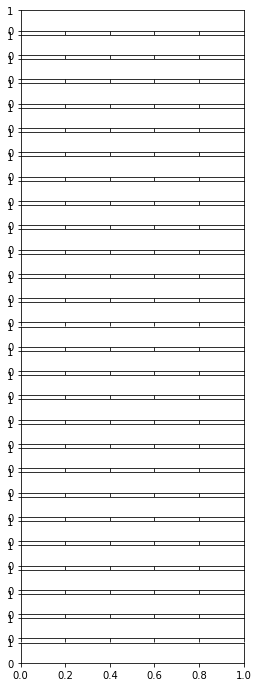

In [152]:
def plot_BT(df, width = 4, height = 12, phenotypes = None, mask):
    
    if phenotypes is None:
        phenotypes = df.Phenotype.unique()
        
    masks = df.MASK.unique()
    
    fig, axes = plt.subplots(nrows=len(phenotypes), sharex=True, figsize=(width, height))

    for ax in range(0, len(phenotypes)):
        temp = df.loc[df.Phenotype.eq(phenotypes[ax]),:]
        temp = temp.loc[df.MASK.isin(masks)]

        temps = [temp[temp.MASK == mask] for mask in masks]
        
    return temps

plot_BT(plt_df)

In [ ]:


for ax in range(0, len(phenotypes)):
    temp = plt_df.loc[plt_df.Phenotype.eq(phenotypes[ax]),:]
    temp = temp.loc[plt_df.MASK.isin(masks)]
    
    temps = [temp[temp.MASK == mask] for mask in masks]
    
    if TRAIT == "BT":
        xerrs = [[temp["OR_se_l"].values, temp["OR_se_u"].values] for temp in temps]
                
    elif TRAIT == "QT":
        xerrs = [temp["OR_se"] for temp in temps]  
       
    axes[ax].errorbar(
        temps[0]["OR"],
        temps[0].index,
        alpha=0.99,
        xerr=xerrs[0],
        fmt="o",
        c="tab:grey",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    axes[ax].errorbar(
        temps[1]["OR"],
        temps[1].index,
        alpha=0.99,
        xerr=xerrs[1],
        fmt="o",
        c="tab:purple",
        ecolor="black",
        ms=ms,
        mew=0.0,
        mec="black",
        elinewidth=lw,
    )
    #axes[ax].errorbar(
    #    temps[2]["OR"],
    #    temps[2].index,
    #    alpha=0.99,
    #    xerr=xerrs[2],
    #    fmt="o",
    #    c="tab:orange",
    #    ecolor="black",
    #    ms=ms,
    #    mew=0.0,
    #    mec="black",
    #    elinewidth=lw,
    #)
    
    ax0 = axes[ax].twinx()
    ax0.set_ylim([0.25, 3.25])
    ax0.set_yticks([1, 2,])
    
    y2labels = (
        temp.N_pos.astype(str)
    #    + temp.or_e.astype(str).str.ljust(5).values
    #    + ["("]
    #    + temp.lower_e.values
    #    + [","]
    #    + temp.upper_e.values
        + ["   p = "]
        + temp.pval_e.values
    )
     
    
    ax0.set_yticklabels(y2labels, fontsize=9, fontdict = {"family": "monospace"})
    ax0.tick_params(right=False)
    ax0.spines["top"].set_alpha(0)
    ax0.spines["left"].set_alpha(0)
    ax0.spines["right"].set_alpha(0)
    ax0.spines["bottom"].set_alpha(0)
    ax0.grid(False)
    # axes[ax].invert_xaxis()
    # only show every 3rd yticklabel
    labels = [l if i % 3 == 0 else "" for i, l in enumerate(temp.Phenotype)]
    axes[ax].set(yticks=temp.index, yticklabels=labels[::-1])
    
    # axes[ax].axvline(x=0, linestyle="--", color="#4f4f4f")
    axes[ax].tick_params(left=False)
    
    if TRAIT == "BT":
        axes[ax].set_xlim([-0.2, 5.2])
        axes[ax].axvline(x=1, linestyle=":", color="#4f4f4f")
    elif TRAIT == "QT":
        axes[ax].set_xlim([-0.22, 0.82])
        axes[ax].axvline(x=0, linestyle=":", color="#4f4f4f")
    
    axes[ax].spines["top"].set_alpha(0)
    axes[ax].spines["left"].set_alpha(0)
    axes[ax].spines["right"].set_alpha(0)
    if ax != len(phenotypes) - 1:
        axes[ax].spines["bottom"].set_alpha(0)
        axes[ax].tick_params(bottom=False)

    if (ax == len(phenotypes) - 1):
        axes[ax].set_xlabel(xlab)
        #ax0.legend(handles = legend_elements, loc = "lower right")
#                
            #axes[len(phenotypes) - 1].set_xticks([0,1,2,3,4,5,6,7,])
for ax in axes.flat:
    ax.margins(0.3)

plt.subplots_adjust(right=1)
#fig.suptitle(title)

#plt.savefig(f"/opt/notebooks/gogoGPCR/tmp/{GENE}_{TRAIT}_new.svg", dpi = 600, bbox_inches="tight", format = "svg")
plt.show()